In [5]:
import hopsworks
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import matplotlib.pyplot as plt
import joblib
import os
os.environ['HOPSWORKS_API_KEY'] = 'cKV1tKzokpcwviY6.uP2qcFV2wWI8xxNu1I0UxyeqlRHqSEanLgKFjf5R1ypSy8A3AUnRkRpi0R9Gc5l0'

In [6]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196759
Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
flood_fg = fs.get_feature_group(name="flood", version=1)
query = flood_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="flood",
                                  version=1,
                                  description="Flood risk prediction",
                                  labels=["severitylevel"],
                                  query=query)

In [8]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.04s) 


In [9]:
X_train

,value
0,0.516
1,0.514
2,0.504
3,0.618
4,0.524
6,0.599
8,0.443
9,0.568
10,0.539
11,0.506


In [10]:
y_train

,severitylevel
0,3
1,3
2,2
3,3
4,3
6,3
8,2
9,3
10,3
11,2


In [14]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean square error : {mse}')


Mean square error : 0.07035908225042754


ValueError: Classification metrics can't handle a mix of binary and continuous targets

As we can see by the displyed accuracies, k=10 is the best value for k

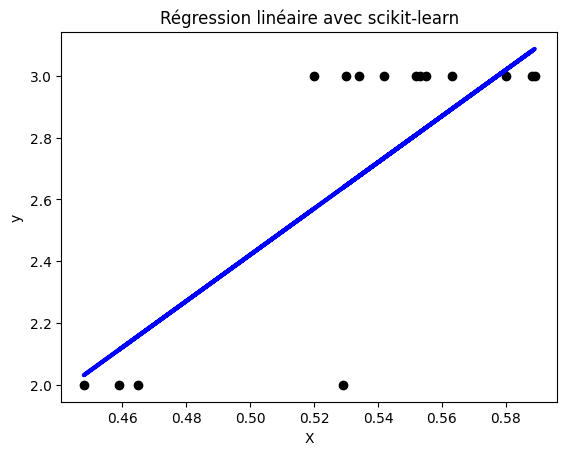

In [12]:
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Régression linéaire avec scikit-learn')
plt.show()

In [15]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="flood_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/flood_model.pkl")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
flood_model = mr.python.create_model(
    name="flood_model",
    metrics={"Mean square error": mse},
    model_schema=model_schema,
    description="Flood risk forecast"
)

# Upload the model to the model registry, including all files in 'model_dir'
flood_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/895 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/272 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/196759/models/flood_model/1


Model(name: 'flood_model', version: 1)